# Uber Case Study - Demand Supply Gap

### 1. Importing the data
we start by importing the regular libraries and reading the file into a dataframe

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

#_____________________________________________________________
#This function below helps us to print content in bold/colored
#in the Jupyter Notebook

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#_____________________________________________________________

sns.set(style='whitegrid')
df=pd.read_csv('Uber Request Data.csv')

Let us check the basic structure of our dataframe

In [3]:
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


Straight up, we see a few things __wrong__ with the data.<br>

>1. We notice that the __timestamp__ columns are being treated as strings. <br>
>2. Among the date entries, some dates have __"\/"__ , whereas some have __"-"__ in them.<br>
>3. This isn't going to work, if we try to analyze based on date and time <br>
>4. Some time entries are in __hh:mm:ss__ format , whereas some in __hh:mm__ format. <br>
>5. Since the Status Column is available , we actually do not need the __Drop timestamp__ columns<br>

### 2. Fixing the Date and Time

We make two new columns __Request Date__ and __Request Time__ from __Request timestamp__. <br>
Once we do that, we do not need the column __Request timestamp, Drop timestamp and Driver id__.

In [5]:
def fix_date(row):
    x=row['Request timestamp'].split(' ')[0]
    
    if x.find('/')>-1:
        dt=datetime.strptime(x,'%d/%m/%Y').date()
    else:
        dt=datetime.strptime(x,'%d-%m-%Y').date()
    
    return dt

def fix_time(row):
    tm=row['Request timestamp'].split(' ')[1]
    return int(tm.split(':')[0])

df['Request Date']=df.apply(fix_date,axis=1)
df['Request Date']=df['Request Date'].apply(pd.to_datetime)
df['Request Time']=df.apply(fix_time,axis=1)
df.drop(['Request timestamp','Drop timestamp','Driver id'],axis=1,inplace=True)

In [6]:
df.head()

,Request id,Pickup point,Status,Request Date,Request Time
0,619,Airport,Trip Completed,2016-07-11,11
1,867,Airport,Trip Completed,2016-07-11,17
2,1807,City,Trip Completed,2016-07-12,9
3,2532,Airport,Trip Completed,2016-07-12,21
4,3112,City,Trip Completed,2016-07-13,8


Since our entire analysis shall be focussed on __Status__ , let us check the Unique values in this column.

In [7]:
printmd('**Unique Possible Status**')
print(df['Status'].unique())
printmd('**Data Spread across Month**')
print(df['Request Date'].dt.month.unique())
printmd('**Data Spread across dates**')
print(df['Request Date'].dt.day.unique())

**Unique Possible Status**

['Trip Completed' 'Cancelled' 'No Cars Available']


**Data Spread across Month**

[7]


**Data Spread across dates**

[11 12 13 14 15]


### 3. Overall Structure of the Problem

So we have __5 days__ worth of data for the month of __July 2016__ as seen above.<br>

Since we have made the basic dataframe, let us make some barcharts to answer these questions<br>
>__Q1__ Is there any specific issue contributing to incomplete trips ?<br>
>__Q2__ Does the pick up point show any asymmetry ?<br>
>__Q3__ Is the same demand pattern noticed in all 5 days ?

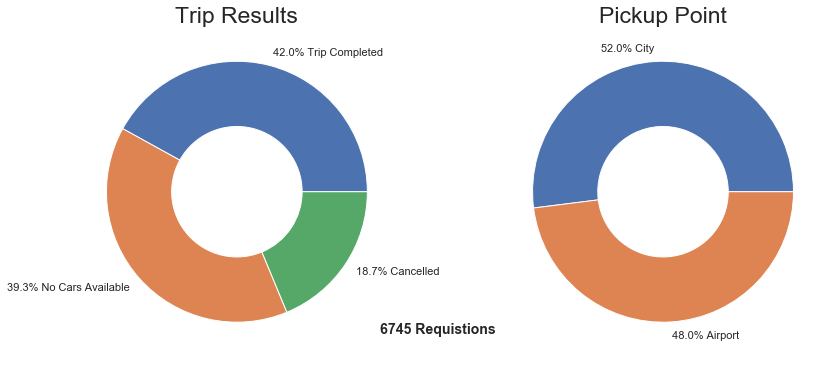

In [8]:
fig1, ax1 = plt.subplots(1,2,figsize=(14, 6))
fig1.suptitle(str(df.shape[0])+' Requistions', fontsize=14,
              fontweight='bold',x = 0.5,y=0.2)

size = 0.5

trip_result=df['Status'].value_counts()
trip_wedges=[str(round(100*a/trip_result.sum(),1))+'% '+b for a,b in zip(trip_result,trip_result.index)]

ax1[0].pie(trip_result, radius=1, wedgeprops=dict(width=size, edgecolor='w'),labels=trip_wedges)
ax1[0].set_title('Trip Results',fontsize= 23)

pkp_pts=df['Pickup point'].value_counts()
pkp_wedges=[str(round(100*a/pkp_pts.sum(),1))+'% '+b for a,b in zip(pkp_pts,pkp_pts.index)]

ax1[1].pie(pkp_pts, radius=1, wedgeprops=dict(width=size, edgecolor='w'),labels=pkp_wedges)
ax1[1].set_title('Pickup Point',fontsize= 23)

plt.show()

The graphs above show that , the number of requests is more or less evenly distributed , whether the destination is __Airport or City__. <br>
However, majority of incomplete trips is because of __No Cars Available__ <br>

This answers Q1 and Q2, but what about Q3. Do we see the same traffic pattern all three days ?<br>
Now , we will assess , if the tarffic volume is reasonable stable or not. To do that, we need to calculate __hourly requests__ for 11th to 15th July.<br>

A groupby maneuver , followed by an unstack , gives us hourly requests for all 5 days

In [9]:
daily_traffic=df[['Request Date','Request Time','Request id']].groupby(['Request Date','Request Time']).count()
daily_traffic=daily_traffic.unstack().T
daily_traffic.head()

Request Date             2016-07-11  2016-07-12  2016-07-13  2016-07-14  \
           Request Time                                                   
Request id 0                     16          16          23          23   
           1                     18          10          17          21   
           2                     14          16          24          24   
           3                     17          14          24          18   
           4                     39          43          40          44   

Request Date             2016-07-15  
           Request Time              
Request id 0                     21  
           1                     19  
           2                     21  
           3                     19  
           4                     37

Text(0, 0.5, 'Requests')

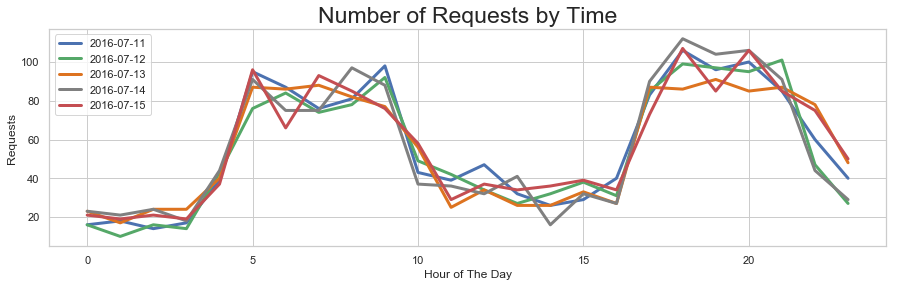

In [26]:
fig2, ax2 = plt.subplots(figsize=(15, 4))

#dates=df['Request Date'].dt.day.unique()
hours=np.arange(0,24)
colors=['b','g','#DD7320','grey','r']
for col,clr in zip(daily_traffic.columns,colors):
    
    ax2.plot(hours, daily_traffic.loc[::,col],color=clr,label=col.date(),linewidth=3.0)

ax2.legend()
ax2.set_title('Number of Requests by Time',fontsize= 23)
ax2.set_xlabel('Hour of The Day')
ax2.set_ylabel('Requests')

### 3. Traffic Volume and Destination

Based on the trend above, we can conclude that we have two peaks , __Peak-1__ from 0500 hrs to 0900 hrs and __Peak-2__ from 1800 hrs to 2100 hrs. These are the durations , when a poor success rate can have serious impact on business<br>.

We now move on to drilling down based on pickup point ( or Destination ). We sum up all the requests in individual hours across 5 days. We create two dataframes, one each for __City__ pickup and __Airport__ pickup. The destinations would be respectively __Airport__ and __City__ 

In [13]:
#This is our City Pickup Dataframe
df_city=df[df['Pickup point']=='City']
df_city=df_city.pivot_table(index='Request Time',columns='Status',values='Request id',aggfunc='count')
df_city=df_city.fillna(0)

#This is our Airport Pickup Dataframe
df_apt=df[df['Pickup point']=='Airport']
df_apt=df_apt.pivot_table(index='Request Time',columns='Status',values='Request id',aggfunc='count')
df_apt=df_apt.fillna(0)

Witn two separate dataframes, we can now visualize, total hourly Trip Status, summed up over the 5 days.

Text(0, 0.5, 'Requests')

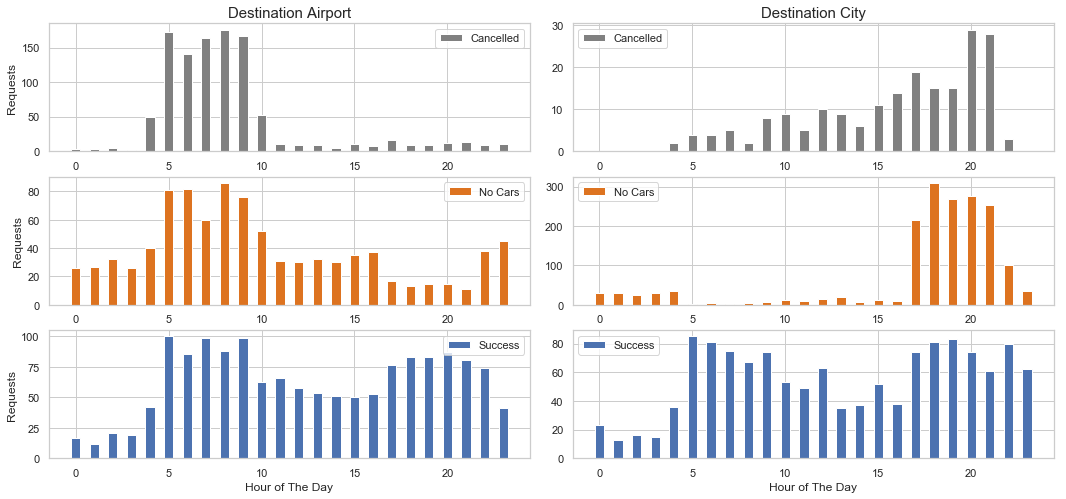

In [32]:
fig3, ax3 = plt.subplots(3,2,figsize=(18, 8))#,sharex=True)
fig3.subplots_adjust(wspace=0.09)

#Plot the bars for Pick-up point at City
ax3[0,0].bar(df_city.index, df_city['Cancelled'], width=0.5, color='grey',label='Cancelled')
ax3[1,0].bar(df_city.index, df_city['No Cars Available'], width=0.5, color='#DD7320',label='No Cars')
ax3[2,0].bar(df_city.index, df_city['Trip Completed'], width=0.5, color='b',label='Success')
ax3[0,0].legend(loc='upper right', frameon=True)
ax3[1,0].legend(loc='upper right', frameon=True)
ax3[2,0].legend(loc='upper right', frameon=True)

#Plot the bars for Pick-up point at Airport
ax3[0,1].bar(df_apt.index, df_apt['Cancelled'], width=0.5, color='grey',label='Cancelled')
ax3[1,1].bar(df_apt.index, df_apt['No Cars Available'], width=0.5, color='#DD7320',label='No Cars')
ax3[2,1].bar(df_apt.index, df_apt['Trip Completed'], width=0.5, color='b',label='Success')
ax3[0,1].legend(loc='upper left', frameon=True)
ax3[1,1].legend(loc='upper left', frameon=True)
ax3[2,1].legend(loc='upper left', frameon=True)

#Add the relevant x and y Axis Labels and Chart Titles 
ax3[2,0].set_xlabel('Hour of The Day')
ax3[2,1].set_xlabel('Hour of The Day')

ax3[0,0].set_title('Destination Airport',fontsize= 15)
ax3[0,1].set_title('Destination City',fontsize= 15)

ax3[0,0].set_ylabel('Requests')
ax3[1,0].set_ylabel('Requests')
ax3[2,0].set_ylabel('Requests')

### 4. Problem Identification

#### Destination Airport
>1. __Trip cancellation__ is a major problem during a specific duration. From 0500 to 0900 hrs almost a total of 100 cases/hr of cancellation are registered across 5 days. <br>
>2. __No cars__ is spread across the entire day , but this also shows a spike at 0500 to 0900hrs.<br>

#### Destination City
>1. Flights landing at night from 1700 to 2200 hrs have a major issue of __No Cars__.
>2. __Cancellation__ shows a steady rise from 0500 hrs and also peaks at 1700 to 2200hrs, when there's already a problem of no cars.<br> 

In [13]:
df_city['Cancel']=100*(df_city['Cancelled']/(df_city.iloc[::,:3:].sum(axis=1)))
df_city['No_Cars']=100*(df_city['No Cars Available']/(df_city.iloc[::,:3:].sum(axis=1)))
df_city['Complete']=100*(df_city['Trip Completed']/(df_city.iloc[::,:3:].sum(axis=1)))

df_apt['Cancel']=100*(df_apt['Cancelled']/(df_apt.iloc[::,:3:].sum(axis=1)))
df_apt['No_Cars']=100*(df_apt['No Cars Available']/(df_apt.iloc[::,:3:].sum(axis=1)))
df_apt['Complete']=100*(df_apt['Trip Completed']/(df_apt.iloc[::,:3:].sum(axis=1)))

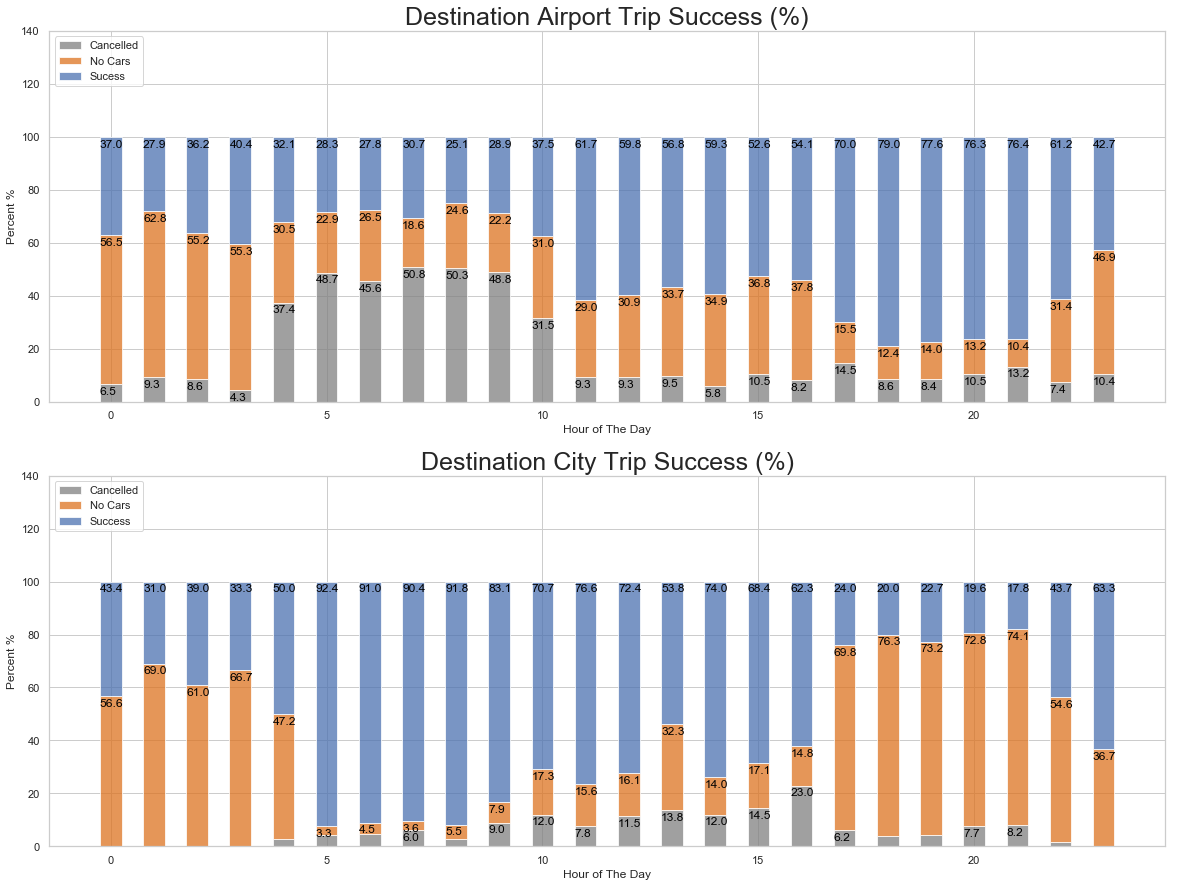

In [17]:
fig4 = plt.figure(figsize=(20, 15))
ax3a=plt.subplot(2,1,1)

plt.bar(df_city.index, df_city['Cancel'], color='grey', 
        edgecolor='white', width=0.5,label='Cancelled',alpha=0.75)
plt.bar(df_city.index, df_city['No_Cars'],bottom=df_city['Cancel'], color='#DD7320',
        edgecolor='white', width=0.5,label='No Cars',alpha=0.75)
plt.bar(df_city.index, df_city['Complete'],
        bottom=[i+j for i,j in zip(df_city['Cancel'], df_city['No_Cars'])], 
        color='b', edgecolor='white', width=0.5,label='Sucess',alpha=0.75)

ax3a.set_ylim([0,140])
ax3a.set_ylabel('Percent %')
ax3a.set_xlabel('Hour of The Day')
ax3a.legend(loc='upper left', frameon=True)
ax3a.set_title('Destination Airport Trip Success (%)',fontsize= 25)

bar_labels=list(df_city['Cancel'])+ \
list(df_city['No_Cars']+df_city['Cancel'])+ \
list(df_city['No_Cars']+df_city['Cancel']+df_city['Complete'])

m=0
for i in ax3a.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax3a.text(i.get_x(), bar_labels[m]-4,str(round(i.get_height(), 1)), fontsize=12,color='black')
    m+=1

ax3a=plt.subplot(2,1,2)

plt.bar(df_apt.index, df_apt['Cancel'], color='grey', 
        edgecolor='white', width=0.5,label='Cancelled',alpha=0.75)
plt.bar(df_apt.index, df_apt['No_Cars'],bottom=df_apt['Cancel'], 
        color='#DD7320', edgecolor='white', width=0.5,label='No Cars',alpha=0.75)
plt.bar(df_apt.index, df_apt['Complete'],
        bottom=[i+j for i,j in zip(df_apt['Cancel'], df_apt['No_Cars'])], 
        color='b', edgecolor='white', width=0.5,label='Success',alpha=0.75)

ax3a.set_ylim([0,140])
ax3a.set_ylabel('Percent %')
ax3a.set_xlabel('Hour of The Day')
ax3a.legend(loc='upper left', frameon=True)
ax3a.set_title('Destination City Trip Success (%)',fontsize= 25)

bar_labels=list(df_apt['Cancel'])+ \
list(df_apt['No_Cars']+df_apt['Cancel'])+ \
list(df_apt['No_Cars']+df_apt['Cancel']+df_apt['Complete'])

m=0
for i in ax3a.patches:
    # get_x pulls left or right; get_height pushes up or down
    if bar_labels[m]>5:
        ax3a.text(i.get_x(), bar_labels[m]-4,str(round(i.get_height(), 1)), fontsize=12,color='black')
        m+=1
    else:
        m+=1

### 5. Final Thoughts

__Peak Hours__
>1. In both the peak hours, __"No Cars"__ seems to cause significant revenue loss.<br>
>2. This is more dominant for arrival flights ( Destination City ) in the 2nd peak duration.<br>
>3. A large number of stranded passengers at arrival !!! <br>

__Off Peak Hours__
>1. These hours do not have much volume, but sure affects Uber Reputation.
>2. On the contrary, despite being low volume hours, success rate is barely 50% !!!

While, it is relatively straightforward to see No-Cars as a major Problem. Some introspection is needed for the Cancellation Problem.

Further Questions that need to be answered

>1. Are the Cancellation primarily by passengers or Drivers ?
>2. From City to Airport , Cancellation plays a major role during 0600hrs to 1900hrs
>3. This could be reluctance of drivers to avoid log waiting times in those hours.
>4. However, why Airport to City causes a linear increase in cancellation ?
>5. Are there specific destination in City which the drivers are reluctant to take.

Further data collection pertaining to Cancellation is requested.
